# IMPLEMENTASI ALGORITMA K-MEANS DENGAN PRINCIPAL COMPONENT ANALYSIS PADA SEGMENTASI PELANGGAN APLIKASI STARBUCKS BERDASARKAN INDIKATOR FREQUENCY, MONETARY, DAN TENURE - Segmentasi (bit.ly/alfianhid_program_skripsi_2)

## Daftar Isi

### [Bagian I: Library dan Data]
### [Bagian II: Perancangan Model Frequency, Monetary, Tenure]
  ##### [1. Pembobotan FMT]
  ##### [2. Distribusi Data]
  ##### [3. Pemotongan Kuantil]
  ##### [4. Normalisasi Data]
### [Bagian III: Segmentasi Pelanggan]
  ##### [1. Principal Component Analysis (PCA)]
  ##### [2. K-Means Clustering]
  ##### [3. Visualisassi Data]
### [Bagian IV: Ringkasan]

## Pendahuluan


Notebook ini melanjutkan dari notebook sebelumnya (`IMPLEMENTASI ALGORITMA K-MEANS DENGAN PRINCIPAL COMPONENT ANALYSIS PADA SEGMENTASI PELANGGAN APLIKASI STARBUCKS BERDASARKAN INDIKATOR FREQUENCY, MONETARY, DAN TENURE - EDA.ipynb`). Di sini, saya akan mencoba menemukan berbagai kelompok demografis pengguna yang memiliki perilaku serupa di aplikasi Starbucks. Saya akan menggunakan metode berikut:


1. `Perancangan Model FMT` (frequency, monetary, tenure)
    - Frequency - seberapa sering pengguna melakukan transaksi
    - Monetary - berapa banyak uang yang dihabiskan pengguna
    - Tenure - berapa lama pengguna telah menggunakan aplikasi
    - Ini biasanya berupa model RFM (recency, frequency, monetary). tetapi `recency` tidak berguna di sini karena hanya ada data transaksi selama 1 bulan, jadi `tenure` akan menggantikan `recency`
    

2. `K-means clustering` - mengelompokkan pengguna ke dalam kluster berdasarkan fitur demografis dan FMT

## Bagian I: Library dan Data

In [ ]:
import joblib
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as subplots

from pandas.testing import assert_frame_equal
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from google.colab import drive

%matplotlib inline
sns.set()

In [ ]:
drive.mount('/content/drive', force_remount=True)

# Data
profile = pd.read_pickle('/content/drive/My Drive/data/out-analysis/profile.pkl')
transcript = pd.read_pickle('/content/drive/My Drive/data/out-analysis/transcript.pkl')
offers = pd.read_pickle('/content/drive/My Drive/data/out-analysis/offers.pkl')
profile.shape, transcript.shape, offers.shape

Mounted at /content/drive


((14825, 10), (272388, 7), (148431, 26))

In [ ]:
print(profile.info())
profile.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 0 to 14824
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   gender        14825 non-null  object        
 1   age           14825 non-null  int64         
 2   income        14825 non-null  int64         
 3   user_id       14825 non-null  int64         
 4   signup_date   14825 non-null  datetime64[ns]
 5   signup_year   14825 non-null  int64         
 6   age_group     14825 non-null  int64         
 7   income_group  14825 non-null  int64         
 8   amount        14825 non-null  float64       
 9   spend_group   14825 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(1)
memory usage: 1.2+ MB
None


,gender,age,income,user_id,signup_date,signup_year,age_group,income_group,amount,spend_group
0,F,55,112000,1,2017-07-15,2017,3,5,77.01,5
1,F,75,100000,2,2017-05-09,2017,5,5,159.27,8
2,M,68,70000,3,2018-04-26,2018,4,3,57.73,4
3,M,65,53000,4,2018-02-09,2018,4,2,36.43,3
4,M,58,51000,5,2017-11-11,2017,3,2,15.62,2


In [ ]:
print(transcript.info())
transcript.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272388 entries, 0 to 272387
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   index     272388 non-null  int64  
 1   event     272388 non-null  object 
 2   time      272388 non-null  int64  
 3   amount    272388 non-null  float64
 4   offer_id  272388 non-null  int64  
 5   reward    272388 non-null  int64  
 6   user_id   272388 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 14.5+ MB
None


,index,event,time,amount,offer_id,reward,user_id
0,0,offer received,0,0.0,7,0,2
1,2,offer received,0,0.0,5,0,3
2,5,offer received,0,0.0,8,0,4
3,7,offer received,0,0.0,1,0,5
4,8,offer received,0,0.0,6,0,6


In [ ]:
print(offers.info())
offers.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148431 entries, 0 to 148430
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   index         148431 non-null  int64         
 1   event         148431 non-null  object        
 2   time          148431 non-null  int64         
 3   offer_id      148431 non-null  int64         
 4   user_id       148431 non-null  int64         
 5   amount        148431 non-null  float64       
 6   reward        148431 non-null  int64         
 7   difficulty    148431 non-null  int64         
 8   duration      148431 non-null  int64         
 9   offer_type    148431 non-null  object        
 10  mobile        148431 non-null  int64         
 11  social        148431 non-null  int64         
 12  web           148431 non-null  int64         
 13  expire_time   148431 non-null  int64         
 14  oid_uid       148431 non-null  object        
 15  viewed        148

,index,event,time,offer_id,user_id,amount,reward,difficulty,duration,offer_type,...,completed,group,gender,age,income,signup_date,signup_year,age_group,income_group,spend_group
0,0,offer received,0,7,2,0.0,5,5,7,bogo,...,1,4,F,75,100000,2017-05-09,2017,5,5,8
1,2,offer received,0,5,3,0.0,2,10,7,discount,...,0,2,M,68,70000,2018-04-26,2018,4,3,4
2,5,offer received,0,8,4,0.0,5,5,5,bogo,...,1,4,M,65,53000,2018-02-09,2018,4,2,3
3,7,offer received,0,1,5,0.0,0,0,4,informational,...,0,1,M,58,51000,2017-11-11,2017,3,2,2
4,8,offer received,0,6,6,0.0,5,20,10,discount,...,0,2,F,61,57000,2017-09-11,2017,4,2,5


## Bagian II: Perancangan Model Frequency, Monetary, Tenure

##### Ini biasanya berupa segmentasi RFM (recency, frequency, monetary). tetapi karena hanya ada 1 bulan data aktivitas, recency menjadi kurang berguna. Alih-alih menggunakan `recency`, saya akan menggunakan `tenure`. Untuk setiap pelanggan, bagian ini akan mengeksplorasi:
- Frequency - seberapa sering pengguna melakukan transaksi
- Monetary - berapa banyak uang yang dihabiskan pengguna
- Tenure - berapa lama pengguna telah menggunakan aplikasi

### 1. Pembobotan FMT

In [ ]:
# Ekstraksi data transaksi
transactions = transcript.query('event == "transaction"').drop('event', axis=1)

# Gabungkan dengan user data
transactions = pd.merge(transactions, profile.drop(['amount', 'spend_group'], axis=1), on='user_id', how='left')
transactions.head()

,index,time,amount,offer_id,reward,user_id,gender,age,income,signup_date,signup_year,age_group,income_group
0,12654,0,0.83,0,0,29,F,20,30000,2016-07-11,2016,1,1
1,12657,0,34.56,0,0,40,M,42,96000,2016-01-17,2016,2,5
2,12659,0,13.23,0,0,46,M,36,56000,2017-12-28,2017,1,2
3,12670,0,19.51,0,0,108,F,55,94000,2017-10-16,2017,3,5
4,12671,0,18.97,0,0,124,F,39,67000,2017-12-17,2017,1,3


In [ ]:
# Buat fitur biner yang menunjukkan apakah jumlah transaksi setidaknya 1 dolar
transactions['gte1'] = transactions.amount.apply(lambda a: int(a >= 1))

# Hitung frequency, monetary untuk semua pengguna
fmt = transactions.groupby('user_id', as_index=False).agg({
    'gte1': 'sum', # frequency
    'amount': 'sum', # monetary
})
fmt.columns = ['user_id', 'frequency', 'monetary']

# Tambahkan pengguna dengan transaksi awal = 0
fmt = pd.merge(profile[['user_id', 'signup_date']], fmt, on='user_id', how='left')
fmt = fmt.set_index('user_id').fillna(0)
fmt['frequency'] = fmt.frequency.astype(int)
fmt.head()

,signup_date,frequency,monetary
user_id,,,
1,2017-07-15,3,77.01
2,2017-05-09,7,159.27
3,2018-04-26,3,57.73
4,2018-02-09,3,36.43
5,2017-11-11,3,15.62


In [ ]:
# Tentukan tanggal referensi untuk pembobotan tenure
ref_date = pd.to_datetime('2021-12-31 00:00')

# Hitung tenure untuk semua pengguna
fmt['tenure'] = fmt.signup_date.apply(lambda d: (ref_date - d).days // 30) # bulan 
fmt.drop('signup_date', axis=1, inplace=True)
fmt.head()

,frequency,monetary,tenure
user_id,,,
1,3,77.01,54
2,7,159.27,56
3,3,57.73,44
4,3,36.43,47
5,3,15.62,50


##### Bagaimana nilai FMT dihitung untuk setiap pengguna:
- `Frequency` - jumlah transaksi yang dilakukan, di mana jumlahnya minimal 1 dolar
- `Monetary` - jumlah total yang dibelanjakan
- `Tenure` - jumlah bulan dari tanggal pendaftaran hingga tanggal referensi
    - Tanggal referensi ditetapkan dengan tanggal pendaftaran ditambah 30 hari

In [ ]:
# Analisis deskriptif
fmt.describe()

,frequency,monetary,tenure
count,14825.000000,14825.000000,14825.000000
mean,7.831771,117.028155,58.733693
std,4.824528,129.965016,13.977843
min,0.000000,0.000000,41.000000
25%,4.000000,31.450000,48.000000
50%,7.000000,87.040000,53.000000
75%,11.000000,160.900000,68.000000
max,33.000000,1608.690000,102.000000


### 2. Distribusi Data

In [ ]:
def FMT_DistributionPlot(fmt_df):
    # Distribusi frequency
    plt.figure(figsize=[5,3])
    fmt_hist = sns.histplot(data = fmt_df, x = 'frequency',  multiple = "dodge", element = 'step', 
                            bins = 30, kde = True, stat = 'count' ).set_title("Distribusi Frequency")
    plt.xlabel("Frequency")
    plt.ylabel("Jumlah pengguna")

    # Distribusi monetary
    plt.figure(figsize=[5,3])
    fmt_hist = sns.histplot(data = fmt_df, x = 'monetary',  multiple = "dodge", element = 'step', 
                            bins = 20, kde = True, stat = 'count' ).set_title("Distribusi Monetary")
    plt.xlabel("Monetary")
    plt.ylabel("Jumlah pengguna")

    # Distribusi tenure
    plt.figure(figsize=[5,3])
    fmt_hist = sns.histplot(data = fmt_df, x = 'tenure',  multiple = "dodge", element = 'step', 
                            bins = 100, kde = True, stat = 'count' ).set_title("Distribusi Tenure")
    plt.xlabel("Tenure (bulan)")
    plt.ylabel("Jumlah pengguna")
    
    return fmt_hist

Text(0.5, 1.0, 'Distribusi Tenure')

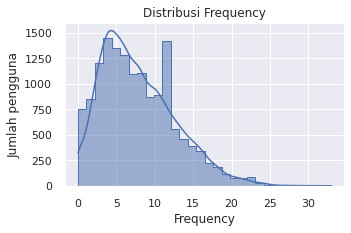

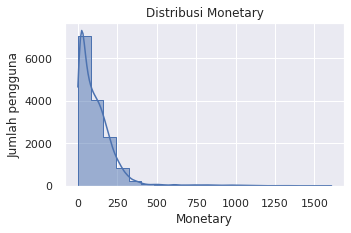

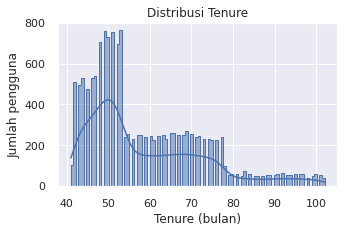

In [ ]:
# tampilkan hasil plotting
FMT_DistributionPlot(fmt)

### 3. Pemotongan Kuantil

In [ ]:
# Memotong dan memperkecil range data ke bentuk kuantil tertentu
fmt['F'] = pd.qcut(fmt.frequency, 6, range(1, 7)).astype(int) # 6 kuantil (1%-16,6%, 16,7%-33,2%, ..., 83,4%-100%)
fmt['M'] = pd.qcut(fmt.monetary, 8, range(1, 9)).astype(int) # 8 kuantil (1%-12,5%, 12,6-25%, ..., 87,6%-100%)
fmt['T'] = pd.qcut(fmt.tenure, 3, range(1, 4)).astype(int) # 3 kuantil (1%-33,3%, 33,4%-66,6%, 66,7%-100%)

# Gabungkan nilai atribut F, M, dan T ke dalam satu atribut FMT
# akan digunakan untuk fungsi agregat yang ada di proses selanjutnya
fmt['FMT'] = fmt['F'].astype(str) + fmt['M'].astype(str) + fmt['T'].astype(str)
fmt.head()

,frequency,monetary,tenure,F,M,T,FMT
user_id,,,,,,,
1,3,77.01,54,1,4,2,142
2,7,159.27,56,3,6,2,362
3,3,57.73,44,1,4,1,141
4,3,36.43,47,1,3,1,131
5,3,15.62,50,1,2,1,121


In [ ]:
# Gabungkan FMT data dengan user data
fmt = pd.merge(profile, fmt.reset_index(), on='user_id', how='left')
fmt.head()

,gender,age,income,user_id,signup_date,signup_year,age_group,income_group,amount,spend_group,frequency,monetary,tenure,F,M,T,FMT
0,F,55,112000,1,2017-07-15,2017,3,5,77.01,5,3,77.01,54,1,4,2,142
1,F,75,100000,2,2017-05-09,2017,5,5,159.27,8,7,159.27,56,3,6,2,362
2,M,68,70000,3,2018-04-26,2018,4,3,57.73,4,3,57.73,44,1,4,1,141
3,M,65,53000,4,2018-02-09,2018,4,2,36.43,3,3,36.43,47,1,3,1,131
4,M,58,51000,5,2017-11-11,2017,3,2,15.62,2,3,15.62,50,1,2,1,121


In [ ]:
# Konversi gender ke dalam fitur biner
# Gender "others" dikategorikan sama dengan wanita (bukan pria = 0)
fmt['male'] = (fmt.gender == 'M').astype(int)
fmt.head()

,gender,age,income,user_id,signup_date,signup_year,age_group,income_group,amount,spend_group,frequency,monetary,tenure,F,M,T,FMT,male
0,F,55,112000,1,2017-07-15,2017,3,5,77.01,5,3,77.01,54,1,4,2,142,0
1,F,75,100000,2,2017-05-09,2017,5,5,159.27,8,7,159.27,56,3,6,2,362,0
2,M,68,70000,3,2018-04-26,2018,4,3,57.73,4,3,57.73,44,1,4,1,141,1
3,M,65,53000,4,2018-02-09,2018,4,2,36.43,3,3,36.43,47,1,3,1,131,1
4,M,58,51000,5,2017-11-11,2017,3,2,15.62,2,3,15.62,50,1,2,1,121,1


### 4. Normalisasi Data

In [ ]:
# Menggunakan MinMax Scaler (MinMax Normalization)
scaler = MinMaxScaler()
cols = ['age','income','frequency', 'monetary','tenure']

userd_normalized = pd.DataFrame(scaler.fit_transform(fmt[cols]), index=fmt.index, columns=cols)
userd_normalized = userd_normalized.set_axis(['age_norm','inc_norm','f_norm', 'm_norm', 't_norm'], axis=1)
userd_normalized.head()

,age_norm,inc_norm,f_norm,m_norm,t_norm
0,0.445783,0.911111,0.090909,0.047871,0.213115
1,0.686747,0.777778,0.212121,0.099006,0.245902
2,0.602410,0.444444,0.090909,0.035886,0.049180
3,0.566265,0.255556,0.090909,0.022646,0.098361
4,0.481928,0.233333,0.090909,0.009710,0.147541


In [ ]:
# pahami data
userd_normalized.describe()

,age_norm,inc_norm,f_norm,m_norm,t_norm
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,0.438476,0.393389,0.237326,0.072747,0.290716
std,0.209442,0.239981,0.146198,0.080789,0.229145
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.289157,0.211111,0.121212,0.019550,0.114754
50%,0.445783,0.377778,0.212121,0.054106,0.196721
75%,0.578313,0.555556,0.333333,0.100019,0.442623
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Menggabungkan tabel hasil normalisasi data dengan FMT data
fmt = pd.concat([fmt, userd_normalized], axis=1)
fmt.head()

,gender,age,income,user_id,signup_date,signup_year,age_group,income_group,amount,spend_group,...,F,M,T,FMT,male,age_norm,inc_norm,f_norm,m_norm,t_norm
0,F,55,112000,1,2017-07-15,2017,3,5,77.01,5,...,1,4,2,142,0,0.445783,0.911111,0.090909,0.047871,0.213115
1,F,75,100000,2,2017-05-09,2017,5,5,159.27,8,...,3,6,2,362,0,0.686747,0.777778,0.212121,0.099006,0.245902
2,M,68,70000,3,2018-04-26,2018,4,3,57.73,4,...,1,4,1,141,1,0.602410,0.444444,0.090909,0.035886,0.049180
3,M,65,53000,4,2018-02-09,2018,4,2,36.43,3,...,1,3,1,131,1,0.566265,0.255556,0.090909,0.022646,0.098361
4,M,58,51000,5,2017-11-11,2017,3,2,15.62,2,...,1,2,1,121,1,0.481928,0.233333,0.090909,0.009710,0.147541


## Bagian III: Segmentasi Pelanggan

### 1. Principal Component Analysis (PCA)

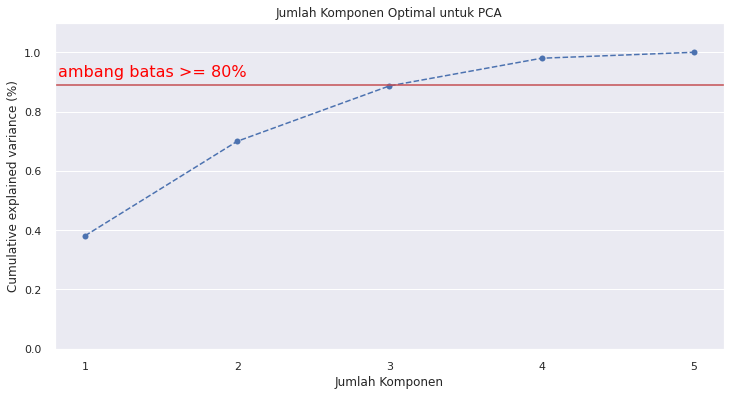

In [ ]:
# menentukan jumlah komponen optimal untuk PCA
pca_test = PCA(random_state=0).fit(userd_normalized)

plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
xi = np.arange(1, 6, step=1)
y = np.cumsum(pca_test.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Jumlah Komponen')
plt.xticks(np.arange(1, 6, step=1))
plt.ylabel('Cumulative explained variance (%)')
plt.title('Jumlah Komponen Optimal untuk PCA')

plt.axhline(y=0.89, color='r', linestyle='-') # 89%
plt.text(0.82, 0.92, 'ambang batas >= 80%', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [ ]:
# Implementasi PCA
pca = PCA(n_components=3, random_state=0)
user_pca = pd.DataFrame(pca.fit_transform(userd_normalized), columns=['comp' + str(i) for i in range(1, 4)])
user_pca.head()

,comp1,comp2,comp3
0,0.455803,-0.091492,-0.270981
1,0.457330,-0.015919,0.003068
2,0.155220,-0.270855,0.108401
3,-0.022680,-0.239550,0.179482
4,-0.088051,-0.198884,0.121273


In [ ]:
print(pca.get_covariance())

[[ 0.04384499  0.01540418 -0.00411623  0.00151834  0.00072858]
 [ 0.01540418  0.05769163 -0.00694042  0.00502352  0.00156568]
 [-0.00411623 -0.00694042  0.01741992  0.00082637  0.01545458]
 [ 0.00151834  0.00502352  0.00082637  0.01125169  0.00425452]
 [ 0.00072858  0.00156568  0.01545458  0.00425452  0.05165689]]


In [ ]:
# pahami data
user_pca.describe()

,comp1,comp2,comp3
count,1.482500e+04,1.482500e+04,1.482500e+04
mean,9.585737e-18,-9.825380e-18,1.114342e-17
std,2.633122e-01,2.406990e-01,1.843059e-01
min,-6.189367e-01,-3.780489e-01,-4.176889e-01
25%,-1.998225e-01,-1.967994e-01,-1.367084e-01
50%,-1.789933e-02,-5.962820e-02,-1.511621e-02
75%,1.919683e-01,1.689454e-01,1.244017e-01
max,7.859343e-01,8.228751e-01,6.376247e-01


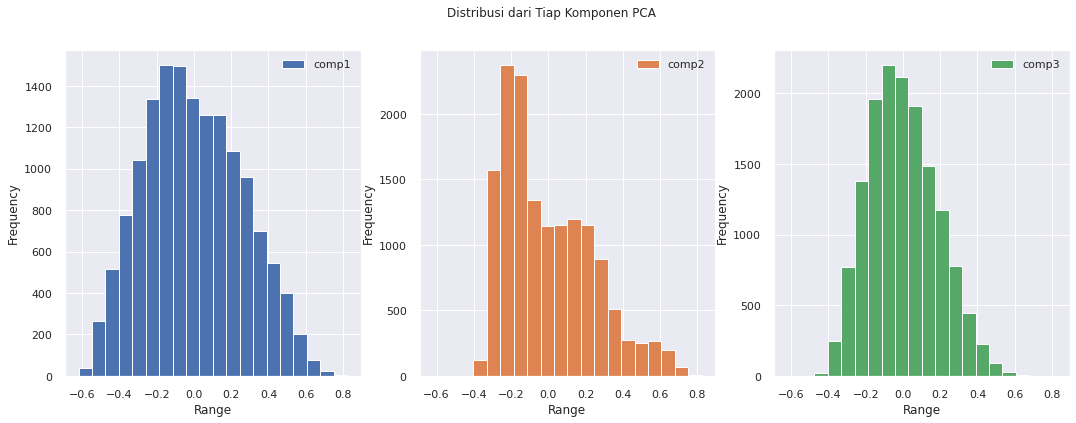

In [ ]:
# plotting histogram PCA
axs = user_pca.plot(kind='hist', bins=20, figsize=(18, 6), subplots=True, layout=(1, 3),
                   title='Distribusi dari Tiap Komponen PCA')
plt.setp(axs[-1, :], xlabel='Range')
plt.show()

In [ ]:
def heatmap(data, title, ylabel, xlabel='Feature', vmin=-1, vmax=1, cmap='RdBu'):
    
    '''
    Plot a heatmap.
    
    Args:
        (1) data (Pandas dataframe) - data to plot
        (2) title (str) - plot name
        (3) xlabel (str) - x-axis name
        (4) ylabel (str) - y-axis name
        (5) vmin (int or float) - colorbar minimum
        (6) vmax (int or float) - colorbar maximum
        (7) cmap (str) - named color palette
        
    Returns: None.
    '''
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, annot=True, vmin=vmin, vmax=vmax, cmap=cmap, fmt='.3f')
    plt.title(title, fontsize='x-large')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yticks(rotation=0)
    plt.show()

In [ ]:
# korelasi tiap component dengan variabel demografis
user_comps = pd.DataFrame(pca.components_, index=user_pca.columns,
                         columns=['age','income','frequency', 'monetary','tenure'])
user_comps.head()

,age,income,frequency,monetary,tenure
comp1,0.530447,0.828408,-0.158600,0.081516,-0.023806
comp2,0.028821,0.064316,0.343324,0.098812,0.931342
comp3,0.844873,-0.531332,0.018905,-0.058507,0.009785


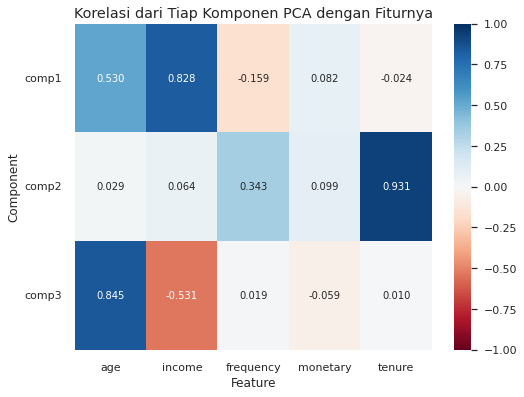

In [ ]:
# Heatmap komponen PCA
heatmap(user_comps, 'Korelasi dari Tiap Komponen PCA dengan Fiturnya', 'Component')

##### `Gender` dikonversi menjadi fitur biner yang menunjukkan apakah pengguna adalah pria karena jumlah pengguna "lainnya" sangat sedikit sehingga mereka dikelompokkan sebagai pengguna "wanita" untuk mewakili pengguna yang bukan pria. Karena ini merupakan fitur kategoris dan pengelompokan K-means tidak dimaksudkan untuk fitur kategoris, saya menggunakan PCA untuk mendapatkan komponen baru (yang merupakan kombinasi linier dari fitur asli) untuk melakukan pengelompokan. Tiga komponen menjelaskan sekitar 89% dari variansi data.

##### Saya akan mencoba mengkarakterisasi setiap komponen berdasarkan nilai bobotnya pada Heatmap. Karakterisasi ini mungkin tidak cukup untuk menjelaskan seluruh esensi komponen, tetapi cukup memberikan gambaran umum.
1. `Component 1` - usia menuju tua dan pendapatan tinggi
2. `Component 2` - frekuensi sedang dan pengguna lama
3. `Component 3` - usia tua dan pendapatan menuju rendah

In [ ]:
# Menggabungkan tabel hasil PCA dengan FMT data
fmt = pd.concat([fmt, user_pca], axis=1)
fmt.head()

,gender,age,income,user_id,signup_date,signup_year,age_group,income_group,amount,spend_group,...,FMT,male,age_norm,inc_norm,f_norm,m_norm,t_norm,comp1,comp2,comp3
0,F,55,112000,1,2017-07-15,2017,3,5,77.01,5,...,142,0,0.445783,0.911111,0.090909,0.047871,0.213115,0.455803,-0.091492,-0.270981
1,F,75,100000,2,2017-05-09,2017,5,5,159.27,8,...,362,0,0.686747,0.777778,0.212121,0.099006,0.245902,0.457330,-0.015919,0.003068
2,M,68,70000,3,2018-04-26,2018,4,3,57.73,4,...,141,1,0.602410,0.444444,0.090909,0.035886,0.049180,0.155220,-0.270855,0.108401
3,M,65,53000,4,2018-02-09,2018,4,2,36.43,3,...,131,1,0.566265,0.255556,0.090909,0.022646,0.098361,-0.022680,-0.239550,0.179482
4,M,58,51000,5,2017-11-11,2017,3,2,15.62,2,...,121,1,0.481928,0.233333,0.090909,0.009710,0.147541,-0.088051,-0.198884,0.121273


### 2. K-Means clustering

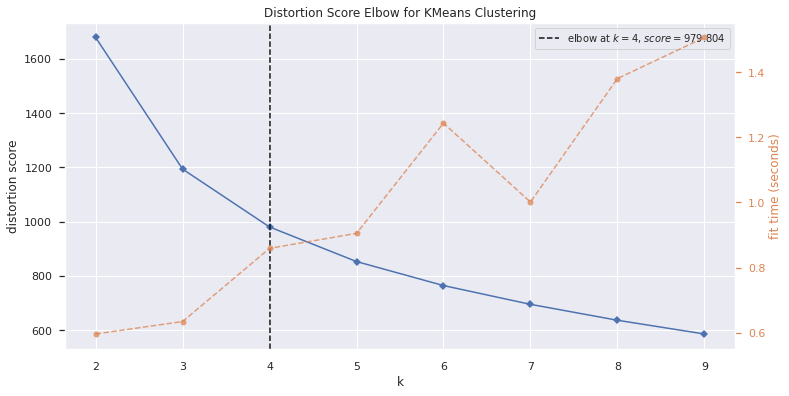

In [ ]:
# menentukan jumlah awal klaster (k)
kelbow_visualizer(KMeans(random_state=0), user_pca, k=(2,10));

In [ ]:
def segment_means(fmt_df, cols=['frequency', 'monetary', 'tenure'],
                  group_col='cols', count_col='FMT'):
    
    '''
    Calculate the frequency, monetary, and tenure (FMT) means for each segment, as well as
    the number and percentage of users in each segment.
    
    Args:
        (1) fmt_df (Pandas dataframe) - FMT data
        (2) cols (list[str]) - names of columns to find the mean for
        (3) group_col (str) - column to group by
        (4) count_col (str) - column to count in the grouping
        
    Returns:
        Frequency, monetary, and tenure (FMT) means and number and percentage of users
        for each segment (Pandas dataframe)
    '''
    
    df = fmt_df.groupby(group_col).mean()[cols].round(2)
    df['n_users'] = fmt_df.groupby(group_col)[count_col].count()
    df['pct_users'] = (100 * df.n_users / fmt_df.shape[0]).round(2)
    return df

In [ ]:
# K-means clustering
kmeans = KMeans(4, random_state=0)
kmeans.fit(user_pca)
fmt['cluster'] = kmeans.labels_

cols = ['age','income','frequency', 'monetary','tenure','comp1','comp2','comp3']
cluster_means = segment_means(fmt, cols, 'cluster') # group by berdasarkan rata-rata (mean)
cluster_means

,age,income,frequency,monetary,tenure,comp1,comp2,comp3,n_users,pct_users
cluster,,,,,,,,,,
0,62.98,92378.19,6.33,173.24,58.47,0.31,0.01,-0.07,4191,28.27
1,34.75,51393.33,7.70,80.53,50.91,-0.25,-0.14,-0.12,3628,24.47
2,52.02,56974.54,11.87,135.00,78.51,-0.12,0.34,0.03,3221,21.73
3,65.73,56143.20,6.18,74.47,49.70,-0.00,-0.16,0.17,3785,25.53


In [ ]:
fmt['customer_cluster'] = fmt.cluster.map({0: 'Gold Customers',
                                           1: 'Silver Customers',
                                           2: 'Diamond Customers',
                                           3: 'Bronze Customers'})
fmt.head()

,gender,age,income,user_id,signup_date,signup_year,age_group,income_group,amount,spend_group,...,age_norm,inc_norm,f_norm,m_norm,t_norm,comp1,comp2,comp3,cluster,customer_cluster
0,F,55,112000,1,2017-07-15,2017,3,5,77.01,5,...,0.445783,0.911111,0.090909,0.047871,0.213115,0.455803,-0.091492,-0.270981,0,Gold Customers
1,F,75,100000,2,2017-05-09,2017,5,5,159.27,8,...,0.686747,0.777778,0.212121,0.099006,0.245902,0.457330,-0.015919,0.003068,0,Gold Customers
2,M,68,70000,3,2018-04-26,2018,4,3,57.73,4,...,0.602410,0.444444,0.090909,0.035886,0.049180,0.155220,-0.270855,0.108401,3,Bronze Customers
3,M,65,53000,4,2018-02-09,2018,4,2,36.43,3,...,0.566265,0.255556,0.090909,0.022646,0.098361,-0.022680,-0.239550,0.179482,3,Bronze Customers
4,M,58,51000,5,2017-11-11,2017,3,2,15.62,2,...,0.481928,0.233333,0.090909,0.009710,0.147541,-0.088051,-0.198884,0.121273,3,Bronze Customers


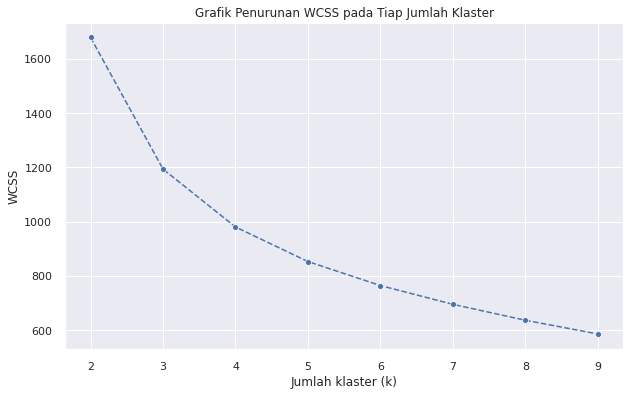

In [ ]:
wcss = []

for k in range(2, 10):
    kmeans = KMeans(k, random_state=0)
    model = kmeans.fit(user_pca)
    wcss.append(model.inertia_)

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(2, 10), y=wcss, linestyle='--', marker='o')
plt.title('Grafik Penurunan WCSS pada Tiap Jumlah Klaster')
plt.ylabel('WCSS')
plt.xlabel('Jumlah klaster (k)')
plt.show()

In [ ]:
# Perhitungan WCSS (Within-cluster Sum of Squares)
print("### Perhitungan WCSS pada Metode Elbow ###")

for k in range(2, 10):
    kmeans = KMeans(k, random_state=0)
    model = kmeans.fit(user_pca)
    wcss = model.inertia_
    if(k==4):
      print("Untuk n_clusters = ", k,", nilai WCSS :", wcss, " (penurunan mulai mendatar)")
    else:
      print("Untuk n_clusters = ", k,", nilai WCSS :", wcss)

### Perhitungan WCSS pada Metode Elbow ###
Untuk n_clusters =  2 , nilai WCSS : 1678.8084582057734
Untuk n_clusters =  3 , nilai WCSS : 1193.2156101205042
Untuk n_clusters =  4 , nilai WCSS : 979.8074361266865  (penurunan mulai mendatar)
Untuk n_clusters =  5 , nilai WCSS : 852.3314224812224
Untuk n_clusters =  6 , nilai WCSS : 763.7462393929491
Untuk n_clusters =  7 , nilai WCSS : 694.539796332911
Untuk n_clusters =  8 , nilai WCSS : 635.8211212597278
Untuk n_clusters =  9 , nilai WCSS : 585.2034364101034


### 3. Visualisasi Data

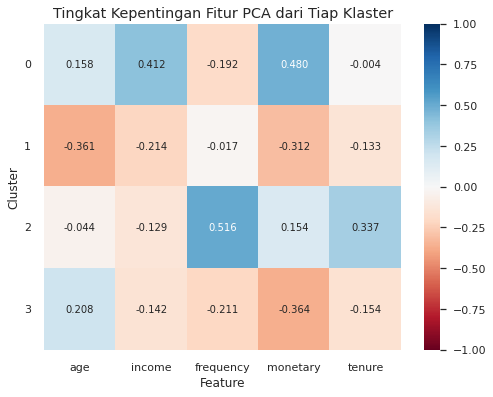

In [ ]:
# heatmap
features = ['age','income','frequency', 'monetary','tenure']
overall_means = fmt[features].mean()
feat_importances = cluster_means.iloc[:, :5] / overall_means - 1
heatmap(feat_importances, 'Tingkat Kepentingan Fitur PCA dari Tiap Klaster', 'Cluster')

In [ ]:
def snake_plot(segment_df, feats=['frequency', 'monetary', 'tenure'],
               normalize=True, segment_col='cluster', user_col='user_id',
               title='Snake Plot', legend_title='Fitur PCA', palette="Set1"):
    
    '''
    Create a snake plot for the specified features of customer segments.
    
    Args:
        (1) segment_df (Pandas dataframe) - user data with defined segments
        (2) feats (list[str]) - names of columns to plot
        (3) normalize (bool) - whether to normalize the data before plotting
        (4) segment_col (str) - name of segment column
        (5) user_col (str) - name of user ID column
        (6) title (str) - plot name
        (7) legend_title (str) - legend name
        (8) palette (list[str] or str) - named color palette or list of colors for bars
        
    Returns: None.
    '''
    
    # Set index
    if user_col in segment_df.columns:
        segment_df.set_index(user_col, inplace=True)
        
    # Normalize values
    if normalize:
        df = pd.DataFrame(StandardScaler().fit_transform(segment_df[feats]), index=segment_df.index, columns=feats)
        df[segment_col] = segment_df[segment_col]
    else:
        df = segment_df[feats]
        
    # Melt features
    melt = pd.melt(df.reset_index(),
                   id_vars=[user_col, segment_col], value_vars=feats,
                   var_name='Feature', value_name='Value')

    # Create a snake plot for customer segments
    title += ' Fitur PCA dari Tiap Klaster'
    sns.lineplot(data=melt, x='Feature', y='Value', hue=segment_col, palette=palette)
    plt.title(title, fontsize='x-large')
    plt.legend(title=legend_title, bbox_to_anchor=(1, 1))
    plt.show()

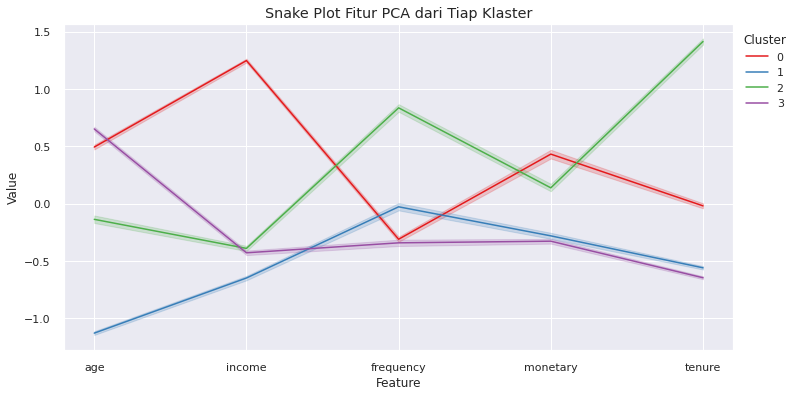

In [ ]:
# Snake plot
snake_plot(fmt, features, segment_col='cluster', legend_title='Cluster')

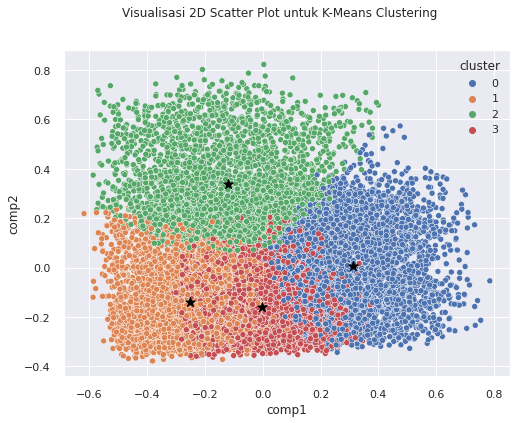

In [ ]:
kmeans = KMeans(4, random_state=0)
kmeans.fit(user_pca)

# 2D scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=fmt, x='comp1', y='comp2', hue='cluster', palette='deep');
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
           s=100, c='black', marker='*', label='Centroid')
fig.suptitle('Visualisasi 2D Scatter Plot untuk K-Means Clustering');

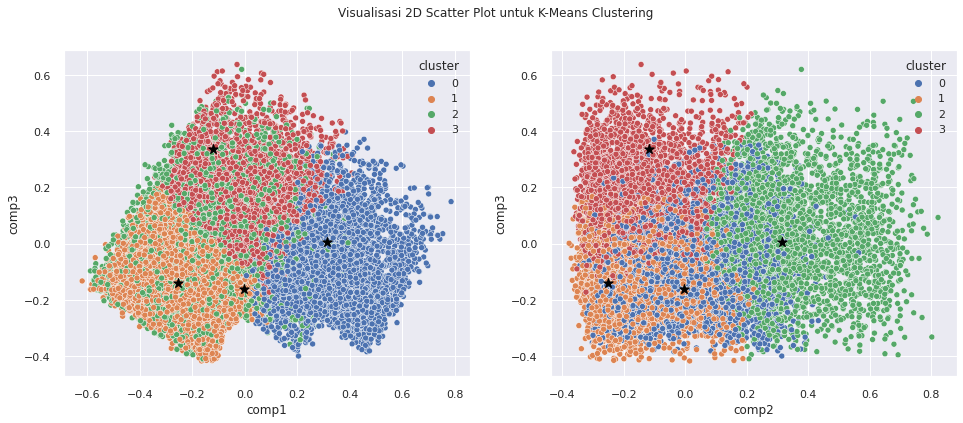

In [ ]:
# 2D scatter plot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.scatterplot(data=fmt, x='comp1', y='comp3', hue='cluster', ax=ax[0], palette='deep');
ax[0].scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
           s=100, c='black', marker='*', label='Centroid')
sns.scatterplot(data=fmt, x='comp2', y='comp3', hue='cluster', ax=ax[1], palette='deep');
ax[1].scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
           s=100, c='black', marker='*', label='Centroid')
fig.suptitle('Visualisasi 2D Scatter Plot untuk K-Means Clustering');

In [ ]:
# 3D scatter plot
nextfig = px.scatter_3d(fmt, x='comp1', y='comp2', z='comp3',
                    color='customer_cluster', size_max=40,
                    title=f'3D Scatter Plot untuk K-Means Clustering (Comp1, Comp2, Comp3)')
nextfig.update_traces(marker=dict(size=6, line=dict(width=1, color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
nextfig.show()

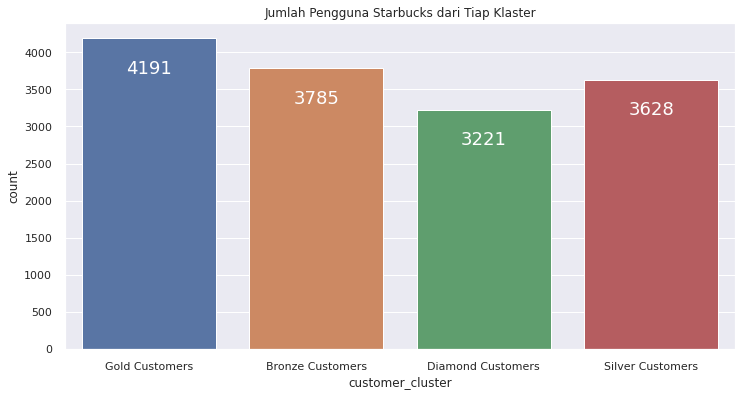

In [ ]:
# count plot
ax = sns.countplot(x='customer_cluster', data=fmt)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=18)
ax.set_title('Jumlah Pengguna Starbucks dari Tiap Klaster');

In [ ]:
feature = ['male','age','income','frequency','monetary','tenure']

def plot_user_demographics(segment_df, segment, color,
                            cols=['gender'] + feature[1:], 
                            segment_col='customer_cluster'):
    
    '''
    Plot the distribution of user demographics and FMT features in a segment.
    
    Args:
        (1) segment_df (Pandas dataframe) - data with defined segments
        (2) segment (str or int) - name of segment
        (3) color (tuple(float, float, float) or str) - RGB tuple or named color for bars
        (3) cols (list[str]) - names of cols to plot
        (4) segment_col (str) - name of segment column
    
    Returns: None.
    '''
    
    # Extract cluster
    cluster = segment_df.loc[segment_df[segment_col] == segment, cols]
    
    # Histogram subplots
    fig, ax = plt.subplots(2, 3, figsize=(16, 6))
    fig.suptitle('Grafik Demografi untuk ' + segment.title(), fontsize='large')
    for i in range(3):
        sns.histplot(cluster[cols[i]], bins=20, color=color, ax=ax[0, i])
        sns.histplot(cluster[cols[i + 3]], bins=20, color=color, ax=ax[1, i])
    plt.show()

In [ ]:
bronze_cust = fmt.query("customer_cluster == 'Bronze Customers'")
bronze_cust = bronze_cust[['gender','age','income','frequency','monetary','tenure']]
bronze_cust.describe()

,age,income,frequency,monetary,tenure
count,3785.000000,3785.000000,3785.000000,3785.000000,3785.000000
mean,65.730515,56143.196830,6.182563,74.471511,49.696962
std,11.066266,13329.302031,4.168138,89.632148,5.715031
min,45.000000,30000.000000,0.000000,0.000000,41.000000
25%,57.000000,46000.000000,3.000000,16.820000,45.000000
50%,64.000000,57000.000000,5.000000,44.330000,49.000000
75%,73.000000,67000.000000,9.000000,105.440000,53.000000
max,101.000000,83000.000000,24.000000,958.190000,73.000000


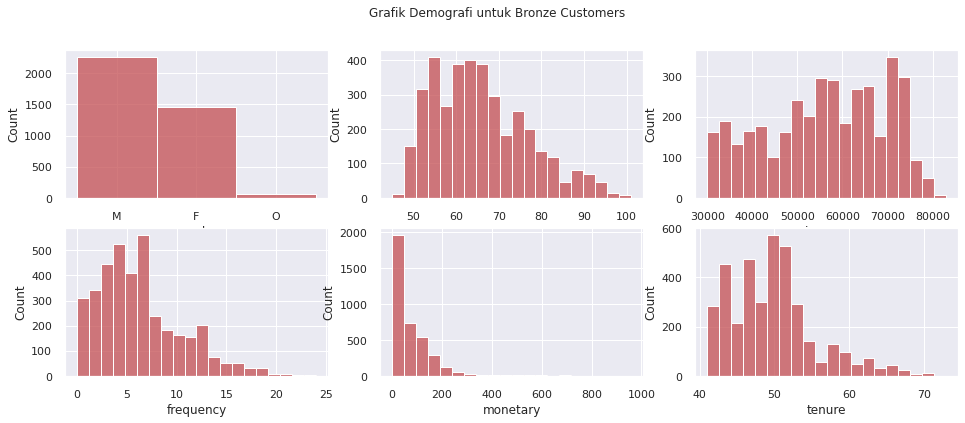

In [ ]:
# histogram untuk bronze customers
plot_user_demographics(fmt, 'Bronze Customers', sns.color_palette()[3])

In [ ]:
silver_cust = fmt.query("customer_cluster == 'Silver Customers'")
silver_cust = silver_cust[['gender','age','income','frequency','monetary','tenure']]
silver_cust.describe()

,age,income,frequency,monetary,tenure
count,3628.000000,3628.000000,3628.000000,3628.000000,3628.000000
mean,34.752205,51393.329658,7.699835,80.532580,50.909041
std,9.523211,13046.265773,4.787693,104.955439,6.408009
min,18.000000,30000.000000,0.000000,0.000000,41.000000
25%,26.000000,40000.000000,4.000000,16.800000,46.000000
50%,35.000000,51000.000000,7.000000,40.185000,50.000000
75%,43.000000,62000.000000,11.000000,118.410000,53.000000
max,55.000000,84000.000000,29.000000,1365.660000,74.000000


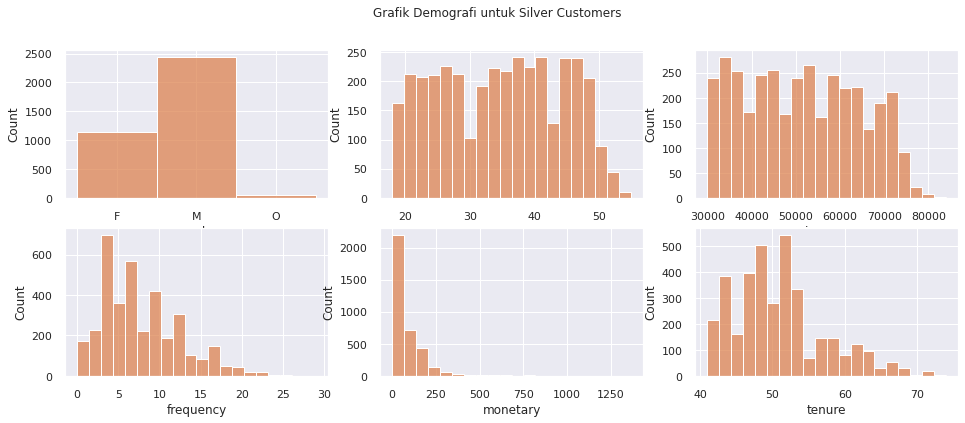

In [ ]:
# histogram untuk silver customers
plot_user_demographics(fmt, 'Silver Customers', sns.color_palette()[1])

In [ ]:
gold_cust = fmt.query("customer_cluster == 'Gold Customers'")
gold_cust = gold_cust[['gender','age','income','frequency','monetary','tenure']]
gold_cust.describe()

,age,income,frequency,monetary,tenure
count,4191.000000,4191.000000,4191.000000,4191.000000,4191.000000
mean,62.984491,92378.191362,6.334049,173.241257,58.467430
std,12.254598,12303.031106,3.496890,160.887420,10.164017
min,36.000000,67000.000000,0.000000,0.000000,41.000000
25%,54.000000,83000.000000,4.000000,88.155000,50.000000
50%,61.000000,91000.000000,6.000000,143.220000,57.000000
75%,71.000000,100000.000000,9.000000,209.995000,67.000000
max,101.000000,120000.000000,23.000000,1608.690000,95.000000


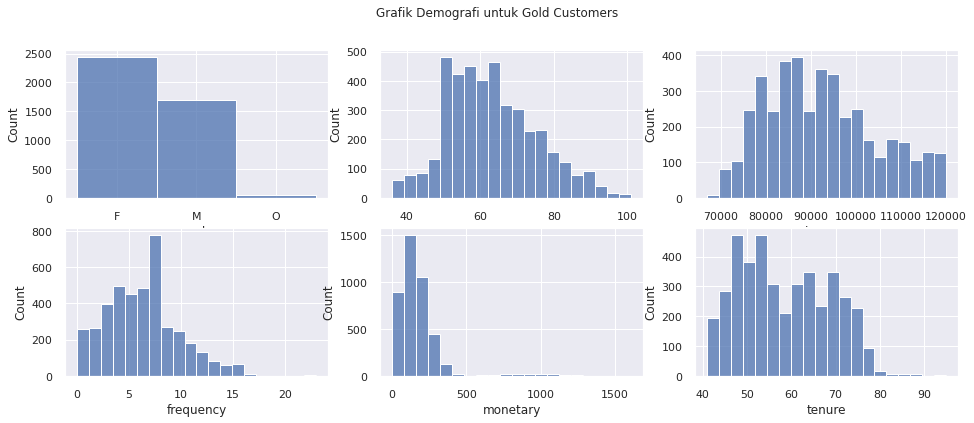

In [ ]:
# histogram untuk gold customers
plot_user_demographics(fmt, 'Gold Customers', sns.color_palette()[0])

In [ ]:
diamond_cust = fmt.query("customer_cluster == 'Diamond Customers'")
diamond_cust = diamond_cust[['gender','age','income','frequency','monetary','tenure']]
diamond_cust.describe()

,age,income,frequency,monetary,tenure
count,3221.000000,3221.000000,3221.000000,3221.000000,3221.000000
mean,52.016455,56974.542068,11.867122,135.001993,78.512574
std,16.195009,14492.297295,4.752218,119.013327,11.136487
min,18.000000,30000.000000,0.000000,0.000000,52.000000
25%,41.000000,46000.000000,8.000000,53.450000,70.000000
50%,53.000000,57000.000000,12.000000,107.360000,76.000000
75%,63.000000,68000.000000,15.000000,181.430000,87.000000
max,100.000000,100000.000000,33.000000,1112.660000,102.000000


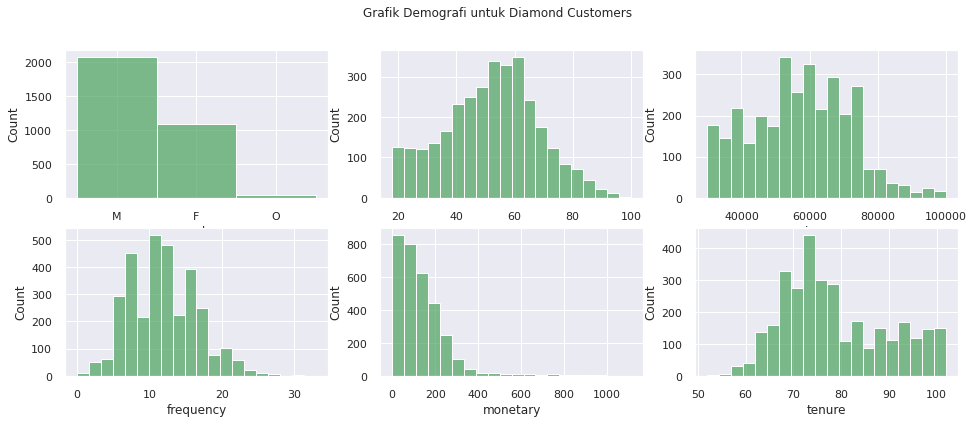

In [ ]:
# histogram untuk diamond customer
plot_user_demographics(fmt, 'Diamond Customers', sns.color_palette()[2])

##### Menggunakan algoritma K-Means dan metode Elbow, saya menemukan bahwa empat klaster adalah jumlah yang optimal karena klaster lebih dapat dibedakan dan lebih dapat diinterpretasikan.

##### Klaster yang dikelompokkan menggunakan histogram memiliki gambaran umum sebagai berikut:
- `Cluster 0` (gold customers) - pengguna dalam grup ini didominasi oleh wanita dengan rentang usia antara 36 - 100 tahun, rentang pendapatan antara USD 67k - 120k per tahun, rentang frekuensi pembelian antara 1 - 9 kali, rentang total pembelian antara USD 1 - 209, dan rentang usia pendaftaran antara 3,5 - 8 tahun
- `Cluster 1` (silver customers) - pengguna dalam grup ini didominasi oleh pria dengan rentang usia antara 18 - 55 tahun, rentang pendapatan antara USD 30k - 84k per tahun, rentang frekuensi pembelian antara 1 - 11 kali, rentang total pembelian antara USD 1 - 118, dan rentang usia pendaftaran antara 3,5 - 6 tahun
- `Cluster 2` (diamond customer) - pengguna dalam grup ini didominasi oleh pria dengan rentang usia antara 18 - 100 tahun, rentang pendapatan antara USD 30k - 100k per tahun, rentang frekuensi pembelian antara 1 - 15 kali, rentang total pembelian antara USD 1 - 181, dan rentang usia pendaftaran antara 4,5 - 8,5 tahun
- `Cluster 3` (bronze customers) - pengguna dalam grup ini didominasi oleh pria dengan rentang usia antara 45 - 100 tahun, rentang pendapatan antara USD 30k - 83k per tahun, rentang frekuensi pembelian antara 1 - 9 kali, rentang total pembelian antara USD 1 - 105, dan rentang usia pendaftaran antara 3,5 - 6 tahun

## Bagian IV: Ringkasan

##### Di notebook ini, saya menggunakan algoritma K-Means clustering - algoritma ini menggabungkan demografi pengguna dengan variabel FMT dan membuat klaster dari kombinasi linear fitur-fitur tersebut. Principal Component Analysis (PCA) digunakan untuk membuat lima komponen (yang merupakan kombinasi linear dari fitur) yang menjelaskan sekitar 89% variansi data.
    
##### Segmentasi pelanggan menggunakan K-Means mengungkapkan beberapa insight. Beberapa di antaranya juga terlihat dalam analisis eksplorasi (EDA) dari notebook sebelumnya (`IMPLEMENTASI ALGORITMA K-MEANS DENGAN PRINCIPAL COMPONENT ANALYSIS PADA SEGMENTASI PELANGGAN APLIKASI STARBUCKS BERDASARKAN INDIKATOR FREQUENCY, MONETARY, DAN TENURE - EDA.ipynb.ipynb`). Saya membuat pengamatan dan kesimpulan berikut berdasarkan hasil segmentasi:
- Pengguna wanita (`cluster 0`) cenderung menghabiskan lebih banyak uang daripada pengguna pria, meskipun mereka berada dalam kelompok usia atau kelompok pendapatan yang sama
- Pengguna berusia muda (`cluster 2`) cenderung melakukan transaksi yang sering, tetapi dalam jumlah kecil
- Ketika pendapatan pengguna meningkat, penmbelanjaan di aplikasi juga meningkat (`cluster 0`)
- Semakin lama pengguna menggunakan aplikasi, semakin nyaman mereka menghabiskan uang di aplikasi (`cluster 2`)
- Seiring bertambahnya usia, pendapatan, dan total pembelanjaan menunjukkan pola yang sangat mirip untuk semua klaster: total pembelian meningkat hingga usia tertentu (sekitar 50-an), kemudian bergerak menurun setelah itu


##### Berdasarkan kebiasaan belanja pengguna, saya akan menyarankan:
1. Targetkan `bronze customers` dan `silver customers` dengan penawaran yang lebih mudah dan turunkan kesulitan dari penawaran karena mereka kurang berminat merespons untuk penawaran yang sulit
2. Kirimkan lebih banyak penawaran informasional kepada `gold customers` dan `diamond customers`, serta tingkatkan kesulitan penawaran reward mereka (diskon dan bogo), karena mereka cenderung berminat merespons untuk beberapa tipe penawaran

### Simpan data

In [ ]:
profile.to_pickle('/content/drive/My Drive/data/out-segmentation/profile.pkl') # user data
transcript.reset_index().to_pickle('/content/drive/My Drive/data/out-segmentation/transcript.pkl') # event data
offers.to_pickle('/content/drive/My Drive/data/out-segmentation/offers.pkl') # transcript of offer-related events
fmt.to_pickle('/content/drive/My Drive/data/out-segmentation/fmt.pkl') # FMT data
joblib.dump(kmeans, '/content/drive/My Drive/data/out-segmentation/kmeans.pkl')
profile.shape, transcript.shape, offers.shape, fmt.shape

((14825, 10), (272388, 7), (148431, 26), (14825, 27))

In [ ]:
userd_normalized.to_pickle('/content/drive/My Drive/data/out-segmentation/normalization.pkl') # normalization result
user_pca.to_pickle('/content/drive/My Drive/data/out-segmentation/pca.pkl') # PCA result
userd_normalized.shape, user_pca.shape

((14825, 5), (14825, 3))